In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests

In [2]:
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [3]:
def download(name, cache_dir=os.path.join('.', 'data')):
    print(os.getcwd())
    assert name in DATA_HUB, f"{name} not in {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        print('file exist')
        print(fname)
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname
    print(f"downloading {fname} from {url}...")
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname
        

In [4]:
def download_extract(name, folder=None):
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname,'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, "only support zip/tar file."
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

In [5]:
def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

In [6]:
# 如果没有安装pandas，请取消下一行的注释
# !pip install pandas

%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l
from sklearn.model_selection import KFold
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

In [7]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [8]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

/
file exist
./data/kaggle_house_pred_train.csv
/
file exist
./data/kaggle_house_pred_test.csv


In [9]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [10]:
all_features.shape

(2919, 79)

In [11]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index

In [12]:
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x -x.mean())/(x.std()))

In [13]:
all_features[numeric_features] = all_features[numeric_features].fillna(0)


In [14]:
all_features = pd.get_dummies(all_features, dummy_na=True)

In [15]:
all_features.shape

(2919, 331)

In [16]:
n_train = train_data.shape[0]

In [17]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

In [18]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

In [19]:
net = nn.Sequential(nn.Linear(in_features, 1))

In [20]:
def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

In [21]:
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate,
          weight_decay, batch_size):
          train_ls, test_ls = [], []
          train_iter = d2l.load_array((train_features, train_labels), batch_size=batch_size)
          
          optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, weight_decay=weight_decay)
          for epoch in range(num_epochs):
              for x, y in train_iter:
                optimizer.zero_grad()
                l = loss(net(x), y)
                l.backward()
                optimizer.step()
              train_ls.append(log_rmse(net, train_features, train_labels))
              if test_labels is not None:
                test_ls.append(log_rmse(net, test_features, test_labels))
          return train_ls, test_ls

In [22]:
def k_fold_train(k, x_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0.0, 0.0
    kf = KFold(n_splits=k)
    for train_idx, test_idx in kf.split(x_train):
        train_ls, valid_ls = train(net, x_train[train_idx], y_train[train_idx], x_train[test_idx], y_train[test_idx], num_epochs, 
                                   learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        print(f'{train_ls[-1]}\t{valid_ls[-1]}')
    d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
    return train_l_sum/k, valid_l_sum/k

0.35749873518943787	0.16001896560192108
0.18195848166942596	0.6455598473548889
0.34698760509490967	0.21139071881771088
0.3575626313686371	0.1512812227010727
0.3519479036331177	0.1847318410873413
5-折验证: 平均训练log rmse: 0.319191, 平均验证log rmse: 0.270597


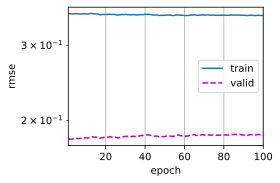

In [26]:
k, num_epochs, lr, weight_decay, batch_size = 7, 100, 0.6, 2, 64
train_l, valid_l = k_fold_train(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')